# Iris Species Preliminary Analysis

In [9]:
! pip install opendp


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from opendp.mod import enable_features
from opendp.measurements import make_laplace
from opendp.domains import atom_domain
from opendp.metrics import absolute_distance
enable_features("contrib")

In [11]:
df_iris = pd.read_csv('../data/Iris.csv')
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
# Selecting values for epsilon
# Low ε (e.g., 0.1, 0.5) → More noise, stronger privacy, but lower accuracy.
# High ε (e.g., 5, 10) → Less noise, higher accuracy, but weaker privacy.

sepal_width = df_iris["SepalWidthCm"].to_numpy()
sepal_length = df_iris["SepalLengthCm"].to_numpy()
delta_1 = np.max(np.abs(np.diff(np.sort(sepal_width)))) 
delta_2 = np.max(np.abs(np.diff(np.sort(sepal_length))))


epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
results_width = {}
results_length = {}

In [13]:
# adding dp for sepal_width
for epsilon in epsilon_values:
    scale = delta_1 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in sepal_width] for _ in range(10)])
    dp_sepal_width = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_sepal_width - sepal_width))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - sepal_width, axis=0).mean()
    emd = wasserstein_distance(sepal_width, dp_sepal_width)
    results_width[epsilon] = {"dp_values": dp_sepal_width, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

In [14]:
# adding dp for sepal_length
for epsilon in epsilon_values:
    scale = delta_2 / epsilon
    laplace_mechanism = make_laplace(
        input_domain=atom_domain(T=float),
        input_metric=absolute_distance(T=float),
        scale=scale
    )
    dp_samples = np.array([[laplace_mechanism(x) for x in sepal_length] for _ in range(10)])
    dp_sepal_length = np.mean(dp_samples, axis=0)
    mae = np.mean(np.abs(dp_sepal_length - sepal_length))
    stability = np.mean(np.std(dp_samples, axis=0))  
    noise_variance = np.var(dp_samples - sepal_length, axis=0).mean()
    emd = wasserstein_distance(sepal_length, dp_sepal_length)
    results_length[epsilon] = {"dp_values": dp_sepal_length, "mae": mae, "emd": emd, "stability": stability,
        "noise_variance": noise_variance}

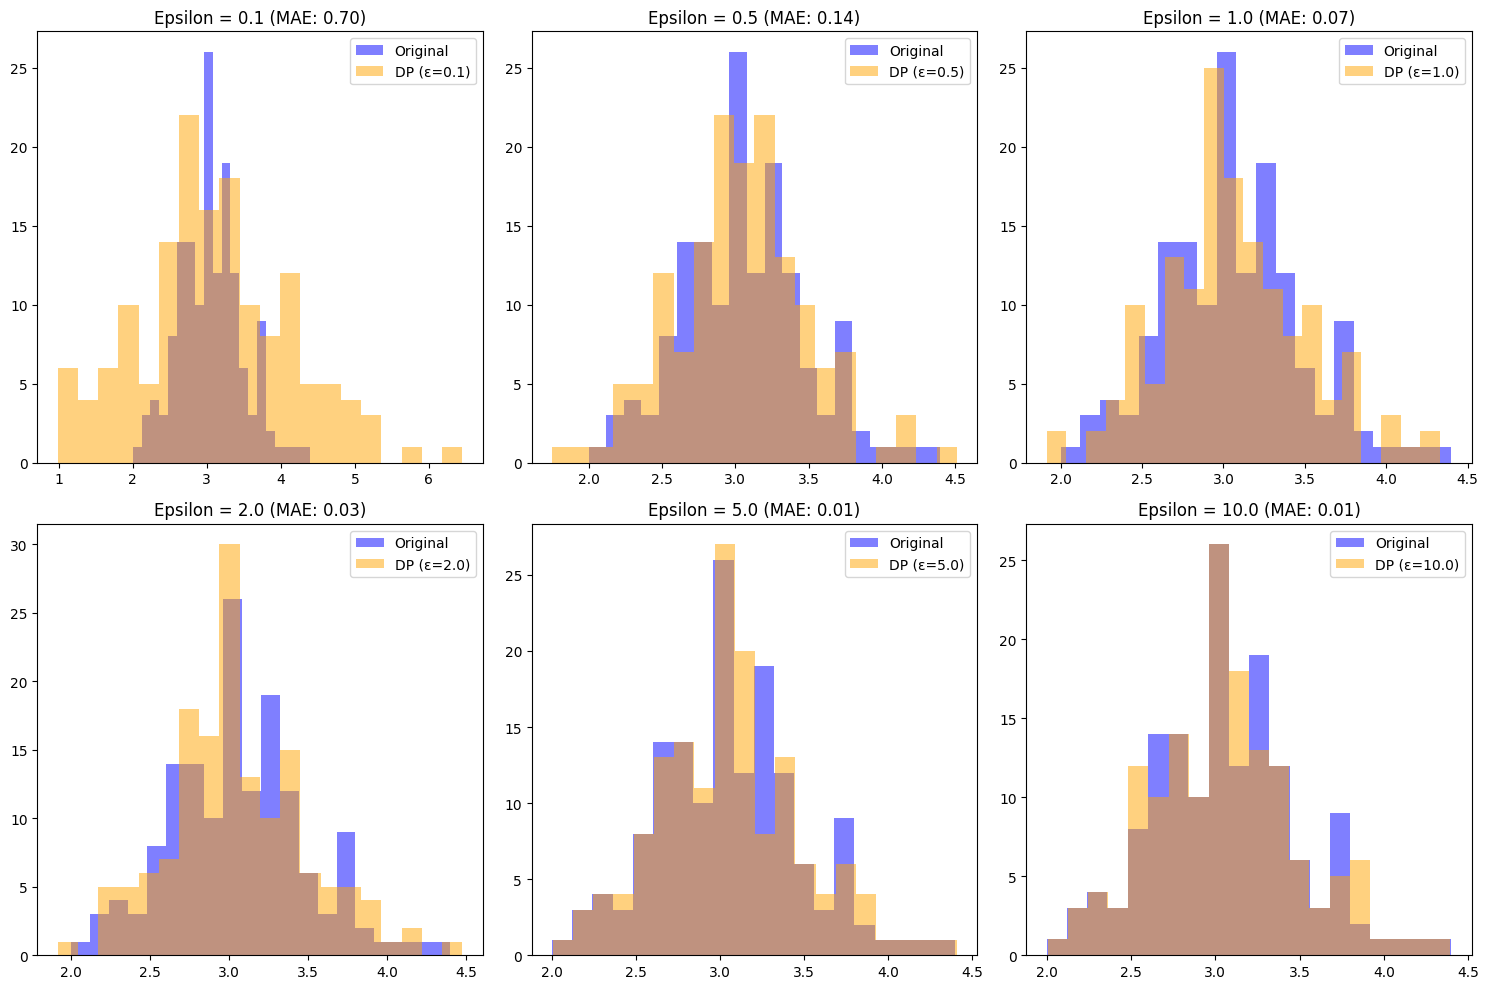

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (epsilon, data) in enumerate(results_width.items()):
    ax = axes[i]
    ax.hist(sepal_width, bins=20, alpha=0.5, label="Original", color='blue')
    ax.hist(data["dp_values"], bins=20, alpha=0.5, label=f"DP (ε={epsilon})", color='orange')
    ax.set_title(f"Epsilon = {epsilon} (MAE: {data['mae']:.2f})")
    ax.legend()

plt.tight_layout()
plt.show()

In [18]:
# metric to measure accuracy
print("\nPrivacy and Utility Metrics:")
print("---------------------------------------------------------")
print(f"{'Epsilon':<10}{'MAE':<10}{'EMD':<10}{'Stability':<12}{'Noise Variance':<15}")
print("---------------------------------------------------------")
for epsilon, data in results_width.items():
    print(f"{epsilon:<10}{data['mae']:.3f}     {data['emd']:.3f}     {data['stability']:.4f}       {data['noise_variance']:.4f}")


Privacy and Utility Metrics:
---------------------------------------------------------
Epsilon   MAE       EMD       Stability   Noise Variance 
---------------------------------------------------------
0.1       0.697     0.483     2.5667       7.2822
0.5       0.144     0.041     0.5105       0.2952
1.0       0.070     0.036     0.2440       0.0655
2.0       0.032     0.028     0.1252       0.0174
5.0       0.014     0.014     0.0501       0.0029
10.0      0.007     0.007     0.0258       0.0008


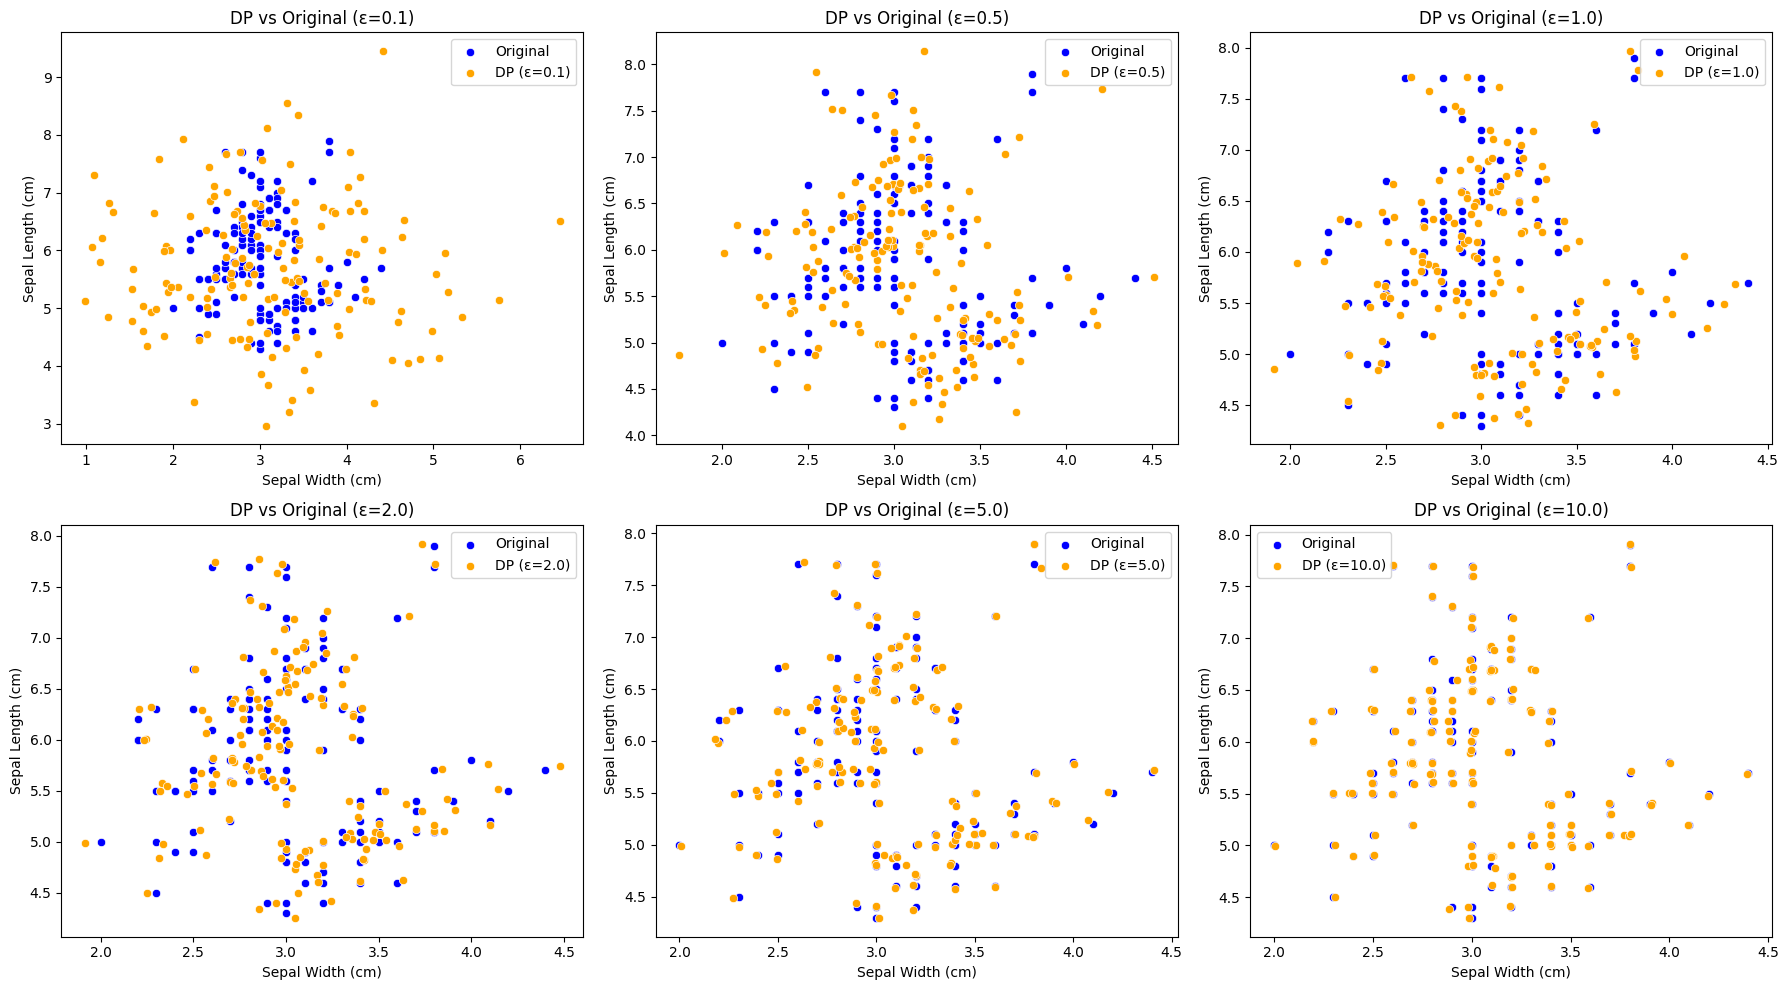

In [17]:
# scatter plot of sepal_width vs sepal_length with dp
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

sorted_epsilons = sorted(results_width.keys())

for i, epsilon in enumerate(sorted_epsilons):
    ax = axes[i]
    sns.scatterplot(
        x=sepal_width,
        y=sepal_length,
        label="Original",
        color="blue",
        ax=ax
    )
    dp_width = results_width[epsilon]["dp_values"]
    dp_length = results_length[epsilon]["dp_values"]
    
    sns.scatterplot(
        x=dp_width,
        y=dp_length,
        label=f"DP (ε={epsilon})",
        color="orange",
        ax=ax
    )
    
    ax.set_title(f"DP vs Original (ε={epsilon})")
    ax.set_xlabel("Sepal Width (cm)")
    ax.set_ylabel("Sepal Length (cm)")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
def compute_2d_emd(original_x, original_y, dp_x, dp_y):
    original_points = np.stack((original_x, original_y), axis=1)
    dp_points = np.stack((dp_x, dp_y), axis=1)

    dist_matrix = cdist(original_points, dp_points)

    emd_2d = np.mean(np.min(dist_matrix, axis=1))
    return emd_2d

### Optimal Epsilon Value

In [ ]:
epsilons = list(results_width.keys())
maes = [results_width[eps]["mae"] for eps in epsilons]
emds = [results_width[eps]["emd"] for eps in epsilons]
stabilities = [results_width[eps]["stability"] for eps in epsilons]
noise_variances = [results_width[eps]["noise_variance"] for eps in epsilons]

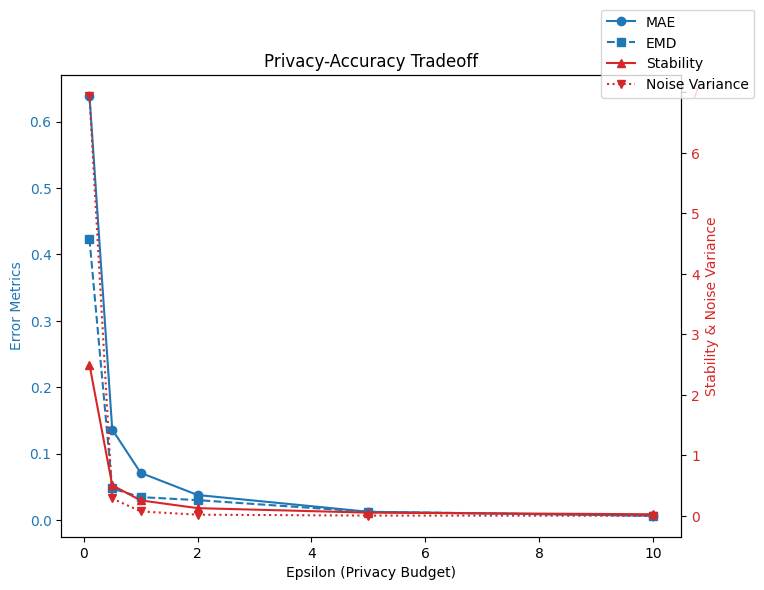

In [27]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.set_xlabel("Epsilon (Privacy Budget)")
ax1.set_ylabel("Error Metrics", color="tab:blue")
ax1.plot(epsilons, maes, label="MAE", marker="o", color="tab:blue")
ax1.plot(epsilons, emds, label="EMD", marker="s", linestyle="dashed", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Stability & Noise Variance", color="tab:red")
ax2.plot(epsilons, stabilities, label="Stability", marker="^", color="tab:red")
ax2.plot(epsilons, noise_variances, label="Noise Variance", marker="v", linestyle="dotted", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.title("Privacy-Accuracy Tradeoff")
plt.show()